In [82]:
import pandas as pd

from biological_fuzzy_logic_networks.DREAM_analysis.utils import (create_bfz, 
                                                                  prepare_cell_line_data, 
                                                                  cl_data_to_input)
import torch
import json
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [83]:
data_folder = "/dccstor/ipc1/CAR/DREAM/"

In [84]:
sc1_winner = pd.read_csv(f"{data_folder}Participants/SC1/icx_bxai_sc1.csv")
sc1_truth = pd.read_csv(f"{data_folder}DREAMdata/Challenge_data/sc1_test_time_aligned.csv", index_col=0)

sc1_winner = sc1_winner.sort_values("glob_cellID")
sc1_truth = sc1_truth.sort_values("glob_cellID")

In [85]:
run_folder = f"{data_folder}Model/Test/MEK_FAK_ERK/26_3/"
ckpt = torch.load(f"{run_folder}model.pt")
with open(f"{run_folder}26_3_config.json") as f:
        config = json.load(f)
model = create_bfz(f"{data_folder}DREAMdata/MEK_FAK_ERK.sif", config["network_class"])
model.load_from_checkpoint(ckpt["model_state_dict"])

In [86]:
cl_data = prepare_cell_line_data(**config) 
    
(
        train_data,
        valid_data,
        train_inhibitors,
        valid_inhibitors,
        train_input,
        valid_input,
        train,
        valid,
        scaler,
    ) = cl_data_to_input(
     data=cl_data,
     model=model,
     train_treatments=config["train_treatments"],
     valid_treatments=config["valid_treatments"],
     train_cell_lines=config["train_cell_lines"],
     valid_cell_lines=config["valid_cell_lines"],
     inhibition_value=config["inhibition_value"],
     minmaxscale=True,
     add_root_values=config["add_root_values"],
     input_value=1)

['BT20' 'BT474' 'BT549' 'CAL148' 'CAL51' 'CAL851' 'DU4475' 'EFM192A'
 'EVSAT' 'HBL100' 'HCC1187' 'HCC1395' 'HCC1419' 'HCC1500' 'HCC1569'
 'HCC1599' 'HCC1937' 'HCC1954' 'HCC2185' 'HCC3153' 'HCC38' 'HCC70' 'HDQP1'
 'JIMT1' 'MCF7' 'MDAMB134VI' 'MDAMB157' 'MDAMB175VII' 'MDAMB361'
 'MDAMB415' 'MDAMB453' 'MFM223' 'MPE600' 'MX1' 'OCUBM' 'T47D' 'UACC812'
 'UACC893' 'ZR7530']
Splitting based on validation cell line(s)


/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM_analysis/utils.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[markers] = scaler.transform(train[markers])
/u/adr/Code/biological_fuzzy_logic_networks/biological_fuzzy_logic_networks/DREAM_analysis/utils.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid[markers] = scaler.transform(valid[markers])


In [87]:
from math import sqrt
def mean_RMSE(ground_truth, predictions, markers=["p.ERK", "p.Akt.Ser473.", "p.S6", "p.HER2", "p.PLCg2"]):
    
    rmse_values = []
    for m in markers:
        for cl in ground_truth["cell_line"].unique():
            rmse = sqrt(sum((ground_truth.loc[ground_truth["cell_line"]==cl, m] - 
                             predictions.loc[predictions["cell_line"]==cl, m])**2) / 
                        len(ground_truth[ground_truth["cell_line"]==cl]))
            rmse_values.append(rmse)
    return sum(rmse_values)/len(rmse_values)

In [88]:
sc1_winner

,glob_cellID,cell_line,treatment,time,cellID,fileID,p.ERK,p.Akt.Ser473.,p.S6,p.HER2,p.PLCg2
0,1,AU565,EGF,0.0,1,59,3.901440,4.186802,5.402692,4.357932,2.280056
1,2,AU565,EGF,0.0,1,122,4.050485,4.431242,7.042006,4.999486,2.807537
2,3,AU565,EGF,0.0,2,59,4.171771,4.566755,6.040624,4.716986,2.456247
3,4,AU565,EGF,0.0,2,122,3.412021,3.618416,5.450850,4.169167,1.795671
4,5,AU565,EGF,0.0,3,59,2.383576,2.730812,3.964737,3.504084,1.459668
...,...,...,...,...,...,...,...,...,...,...,...
2383053,2383054,MDAMB436,iPKC,40.0,3563,2108,4.103123,4.384158,7.069998,4.702792,2.854447
2383054,2383055,MDAMB436,iPKC,40.0,3564,2108,3.982192,4.499595,7.004058,4.785437,3.004326
2383055,2383056,MDAMB436,iPKC,40.0,3565,2108,3.698230,4.565942,7.264115,4.523724,2.598044
2383056,2383057,MDAMB436,iPKC,40.0,3566,2108,2.570859,3.822638,4.720550,2.993271,1.501598


In [89]:
sc1_winner[["cell_line", "treatment", "time", "cellID", "fileID"]].drop_duplicates()

,cell_line,treatment,time,cellID,fileID
0,AU565,EGF,0.0,1,59
1,AU565,EGF,0.0,1,122
2,AU565,EGF,0.0,2,59
3,AU565,EGF,0.0,2,122
4,AU565,EGF,0.0,3,59
...,...,...,...,...,...
2383053,MDAMB436,iPKC,40.0,3563,2108
2383054,MDAMB436,iPKC,40.0,3564,2108
2383055,MDAMB436,iPKC,40.0,3565,2108
2383056,MDAMB436,iPKC,40.0,3566,2108


In [6]:
sc1_truth

,glob_cellID,cell_line,treatment,time,cellID,fileID,p.ERK,p.Akt.Ser473.,p.S6,p.HER2,p.PLCg2
0,1,AU565,EGF,0.0,1,59,2.161190,3.205339,6.83042,4.626783,1.995542
1,2,AU565,EGF,0.0,1,122,3.665097,3.893094,7.65064,4.713031,2.738222
2,3,AU565,EGF,0.0,2,59,4.326529,4.902871,7.67852,5.207019,1.631741
3,4,AU565,EGF,0.0,2,122,2.391616,3.246099,5.90715,3.414914,2.404445
4,5,AU565,EGF,0.0,3,59,1.557082,1.271263,2.46928,4.383723,0.986227
...,...,...,...,...,...,...,...,...,...,...,...
2383053,2383054,MDAMB436,iPKC,40.0,3563,2108,4.099454,4.580278,4.50455,3.499509,2.347711
2383054,2383055,MDAMB436,iPKC,40.0,3564,2108,3.680623,4.352142,6.43669,3.533757,2.389125
2383055,2383056,MDAMB436,iPKC,40.0,3565,2108,3.319599,5.045283,4.85734,3.331996,1.906681
2383056,2383057,MDAMB436,iPKC,40.0,3566,2108,2.152803,4.370816,2.48743,2.313594,1.386166


In [7]:
mean_RMSE(sc1_truth.sort_values("glob_cellID"), sc1_winner.sort_values("glob_cellID"))

0.8551523556310505

In [8]:
mean_RMSE(sc1_truth[sc1_truth["time"]==9.], 
          sc1_winner[sc1_winner["time"]==9.], markers=["p.Akt.Ser473."])

0.8436160585600524

In [74]:
run_folder = f"{data_folder}Model/Test/MEK_FAK_ERK/26_3/"

test_output = pd.read_csv(f"{run_folder}test_output_states.csv", index_col=0).reset_index(drop=True)
test_data = pd.read_csv(f"{run_folder}test_data.csv", index_col=0).reset_index(drop=True)



test_unscaled = pd.DataFrame(scaler.inverse_transform(test_output[["ERK12", "FAK", "MEK12"]]),
                            columns=test_output.columns, index=test_output.index)
test_output = test_output.rename(columns={"ERK12": "p.ERK"})
test_output[["treatment", "cell_line", "time", "cellID", "fileID"]] = test_data[["treatment", "cell_line", "time", "cellID", "fileID"]]
test_unscaled = test_unscaled.rename(columns={"ERK12": "p.ERK"})
test_unscaled[["treatment", "cell_line", "time", "cellID", "fileID"]] = test_data[["treatment", "cell_line", "time", "cellID", "fileID"]]

/tmp/ipykernel_1994849/1999642592.py:4: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv(f"{run_folder}test_data.csv", index_col=0).reset_index(drop=True)


In [41]:
pd.testing.assert_frame_equal(test_unscaled[["treatment", "cell_line", 'time', 'cellID', "fileID"]].reset_index(drop=True),
              sc1_truth.loc[sc1_truth["time"]==9, ["treatment", "cell_line", 'time', 'cellID', "fileID"]].reset_index(drop=True))
pd.testing.assert_frame_equal(test_data[["treatment", "cell_line", 'time', 'cellID', "fileID"]].reset_index(drop=True),
              sc1_winner.loc[sc1_winner["time"]==9, ["treatment", "cell_line", 'time', 'cellID', "fileID"]].reset_index(drop=True))
pd.testing.assert_frame_equal(sc1_truth.loc[sc1_truth["time"]==9, ["treatment", "cell_line", 'time', 'cellID', "fileID"]].reset_index(drop=True),
              sc1_winner.loc[sc1_winner["time"]==9, ["treatment", "cell_line", 'time', 'cellID', "fileID"]].reset_index(drop=True))


In [51]:
truth_subset = sc1_truth[sc1_truth["time"]==9].reset_index(drop=True)
winner_subset = sc1_winner[sc1_winner["time"]==9].reset_index(drop=True)

In [52]:
mean_RMSE(truth_subset, winner_subset, markers=["p.ERK"])

0.625982092621164

In [53]:
mean_RMSE(truth_subset, test_unscaled, markers=["p.ERK"])

0.9004408623109175

<AxesSubplot:xlabel='p.ERK', ylabel='p.ERK'>

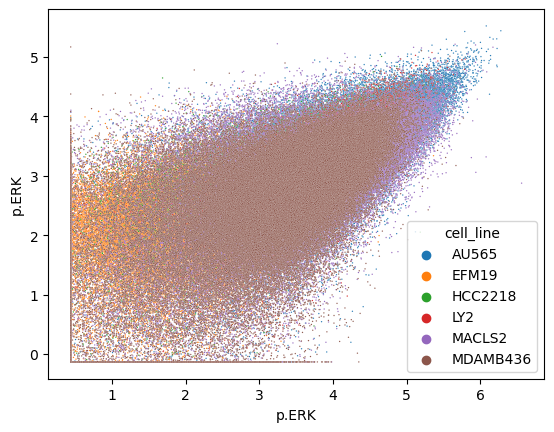

In [54]:
sns.scatterplot(x=truth_subset["p.ERK"], y=test_unscaled["p.ERK"], hue=test_unscaled["cell_line"], s=1)

<AxesSubplot:xlabel='p.ERK', ylabel='p.ERK'>

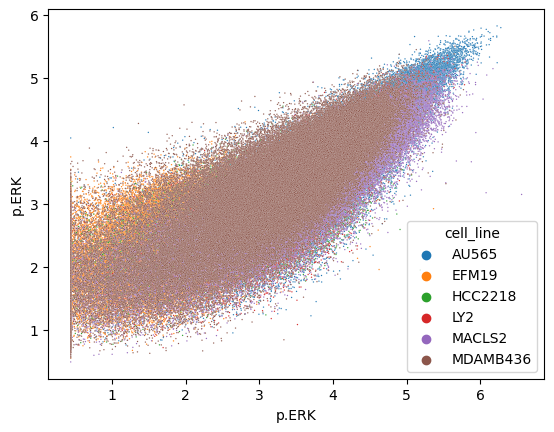

In [55]:
sns.scatterplot(x=truth_subset["p.ERK"], y=winner_subset["p.ERK"], hue=winner_subset["cell_line"], s=1)

In [62]:
print(truth_subset["p.ERK"].max())
print(truth_subset["p.ERK"].min())

6.5593
0.442259


In [61]:
print(test_unscaled["p.ERK"].max())
print(test_unscaled["p.ERK"].min())


5.523750000000001
-0.13242803900000058


In [77]:
truth_scaler = MinMaxScaler()
truth_scaled = truth_subset.copy()
truth_scaled[["p.ERK", "p.Akt.Ser473.", 
              "p.S6", "p.HER2", "p.PLCg2"]] = truth_scaler.fit_transform(truth_subset[["p.ERK", "p.Akt.Ser473.", "p.S6", 
                                                            "p.HER2", "p.PLCg2"]])


winner_scaler = MinMaxScaler()
winner_scaled = winner_subset.copy()
winner_scaled[["p.ERK", "p.Akt.Ser473.", 
              "p.S6", "p.HER2", "p.PLCg2"]] = winner_scaler.fit_transform(winner_subset[["p.ERK", "p.Akt.Ser473.", "p.S6", 
                                                            "p.HER2", "p.PLCg2"]])

test_scaler = MinMaxScaler()
test_scaled = test_output.copy()
test_scaled[["p.ERK"]] = test_scaler.fit_transform(test_output[["p.ERK"]])


In [75]:
mean_RMSE(truth_scaled, winner_scaled, markers=["p.ERK"])

0.10841486295865015

In [78]:
mean_RMSE(truth_scaled, test_scaled, markers=["p.ERK"])

0.27946032656684383

<AxesSubplot:xlabel='p.ERK', ylabel='p.ERK'>

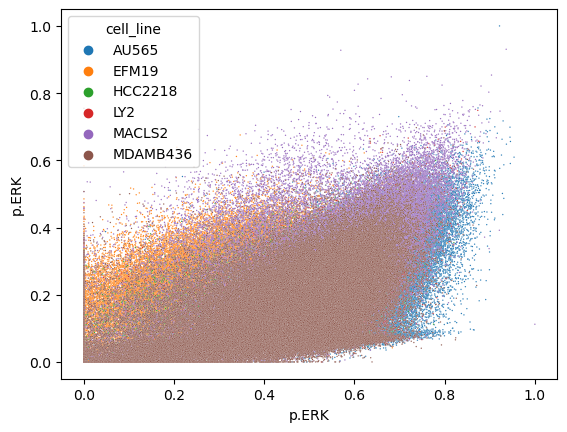

In [81]:
sns.scatterplot(x=truth_scaled["p.ERK"], y=test_scaled["p.ERK"], hue=test_scaled["cell_line"], s=1)

<AxesSubplot:xlabel='p.ERK', ylabel='p.ERK'>

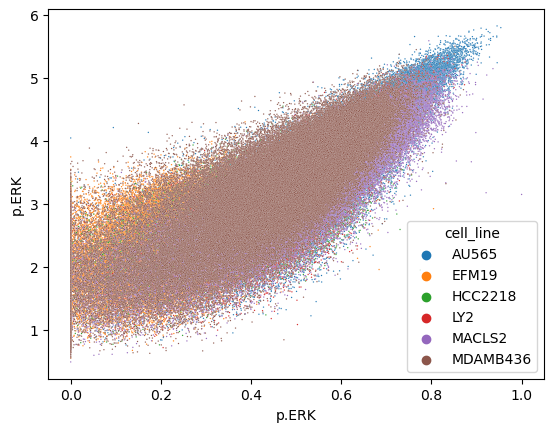

In [80]:
sns.scatterplot(x=truth_scaled["p.ERK"], y=winner_subset["p.ERK"], hue=winner_scaled["cell_line"], s=1)

In [23]:
test_cell_lines = ["AU565", "MDAMB436", "EFM19", "HCC2218", "LY2", "MACLS2"]
test_file_paths = [f"{data_folder}DREAMdata/{CL}.csv" for CL in test_cell_lines]

cl_data = prepare_cell_line_data(
        data_file=test_file_paths,
        time_point=9)

(   train_data,
    valid_data,
    train_inhibitors,
    valid_inhibitors,
    train_input,
    valid_input,
    train,
    valid,
    scaler,
)= cl_data_to_input(
    data=cl_data,
    model=model,
    train_treatments=None,
    valid_treatments=None,
    train_cell_lines=None,
    valid_cell_lines=None,
    inhibition_value=1,
    minmaxscale=True,
    add_root_values=False,
    input_value=None,
    root_nodes=None
)

all_test_data = {node: torch.cat((train_data[node], valid_data[node])) for node in train_data.keys()}
all_test_input = {node: torch.cat((train_input[node], valid_input[node])) for node in train_input.keys()}
all_test_inhibitors = {node: torch.cat((train_inhibitors[node], valid_inhibitors[node])) for node in train_inhibitors.keys()}
all_test = (pd.concat([train, valid])[["MEK12", "FAK", "ERK12", "treatment"]]).reset_index(drop=True)

['AU565' 'MDAMB436' 'EFM19' 'HCC2218' 'LY2' 'MACLS2']


In [24]:
a = cl_data_to_input(
    data=cl_data,
    model=model,
    train_treatments=None,
    valid_treatments=None,
    train_cell_lines=None,
    valid_cell_lines=None,
    inhibition_value=1,
    minmaxscale=True,
    add_root_values=False,
    input_value=None,
    root_nodes=None
)

In [25]:
with torch.no_grad():
    model.set_network_ground_truth(all_test_data)
    model.sequential_update(model.root_nodes, all_test_inhibitors)